# **Case Study - Identifying Relavant US Economy News Articles**

The dataset below consists of 8000 news articles annotated with whether or not they're relavant to US economy (i.e., a yes/no binary classification). The dataset is known to be imbalanced.

### **Reading the data and basic EDA**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/full_economic_news_articles.csv", encoding="latin1")

df.head()

,relevance,articleid,date,headline,text
0,yes,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,no,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,no,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,no,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,yes,wsj_398838054,10-04-2002,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
df.shape

(8000, 5)

In [4]:
# Relevant Article: Talks about Economy

df.loc[0, 'text']

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [5]:
# Non Relevant Article: Looks like talking about Health Insurance

df.loc[1, 'text']

'The Wall Street Journal Online</br></br>The Morning Brief, a look at the day\'s biggest news, is emailed to subscribers by 7 a.m. every business day. Sign up for the e-mail here.</br></br>On Friday evening, with Congress out of town on its summer recess and Americans heading into a mid-August weekend, the Bush administration sent a message to the states: The federal government will make it tougher for a national children\'s insurance program to cover the offspring of middle-income families.</br></br>The State Children\'s Health Insurance Program was created in 1997 to help children whose families couldn\'t afford insurance but didn\'t qualify for Medicaid, and administration officials tell the New York Times that the changes are aimed at returning the program to its low- income focus and assuring it didn\'t become a replacement for private insurance. Administration point man Dennis Smith wrote to state officials saying there would be new restrictions on the District of Columbia and th

In [6]:
# Distribution on target variable looks non-uniform

df['relevance'].value_counts(normalize=True)

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: proportion, dtype: float64

In [7]:
# Visuallizing an overall Word Cloud from the given data

from wordcloud import WordCloud

wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['text']))

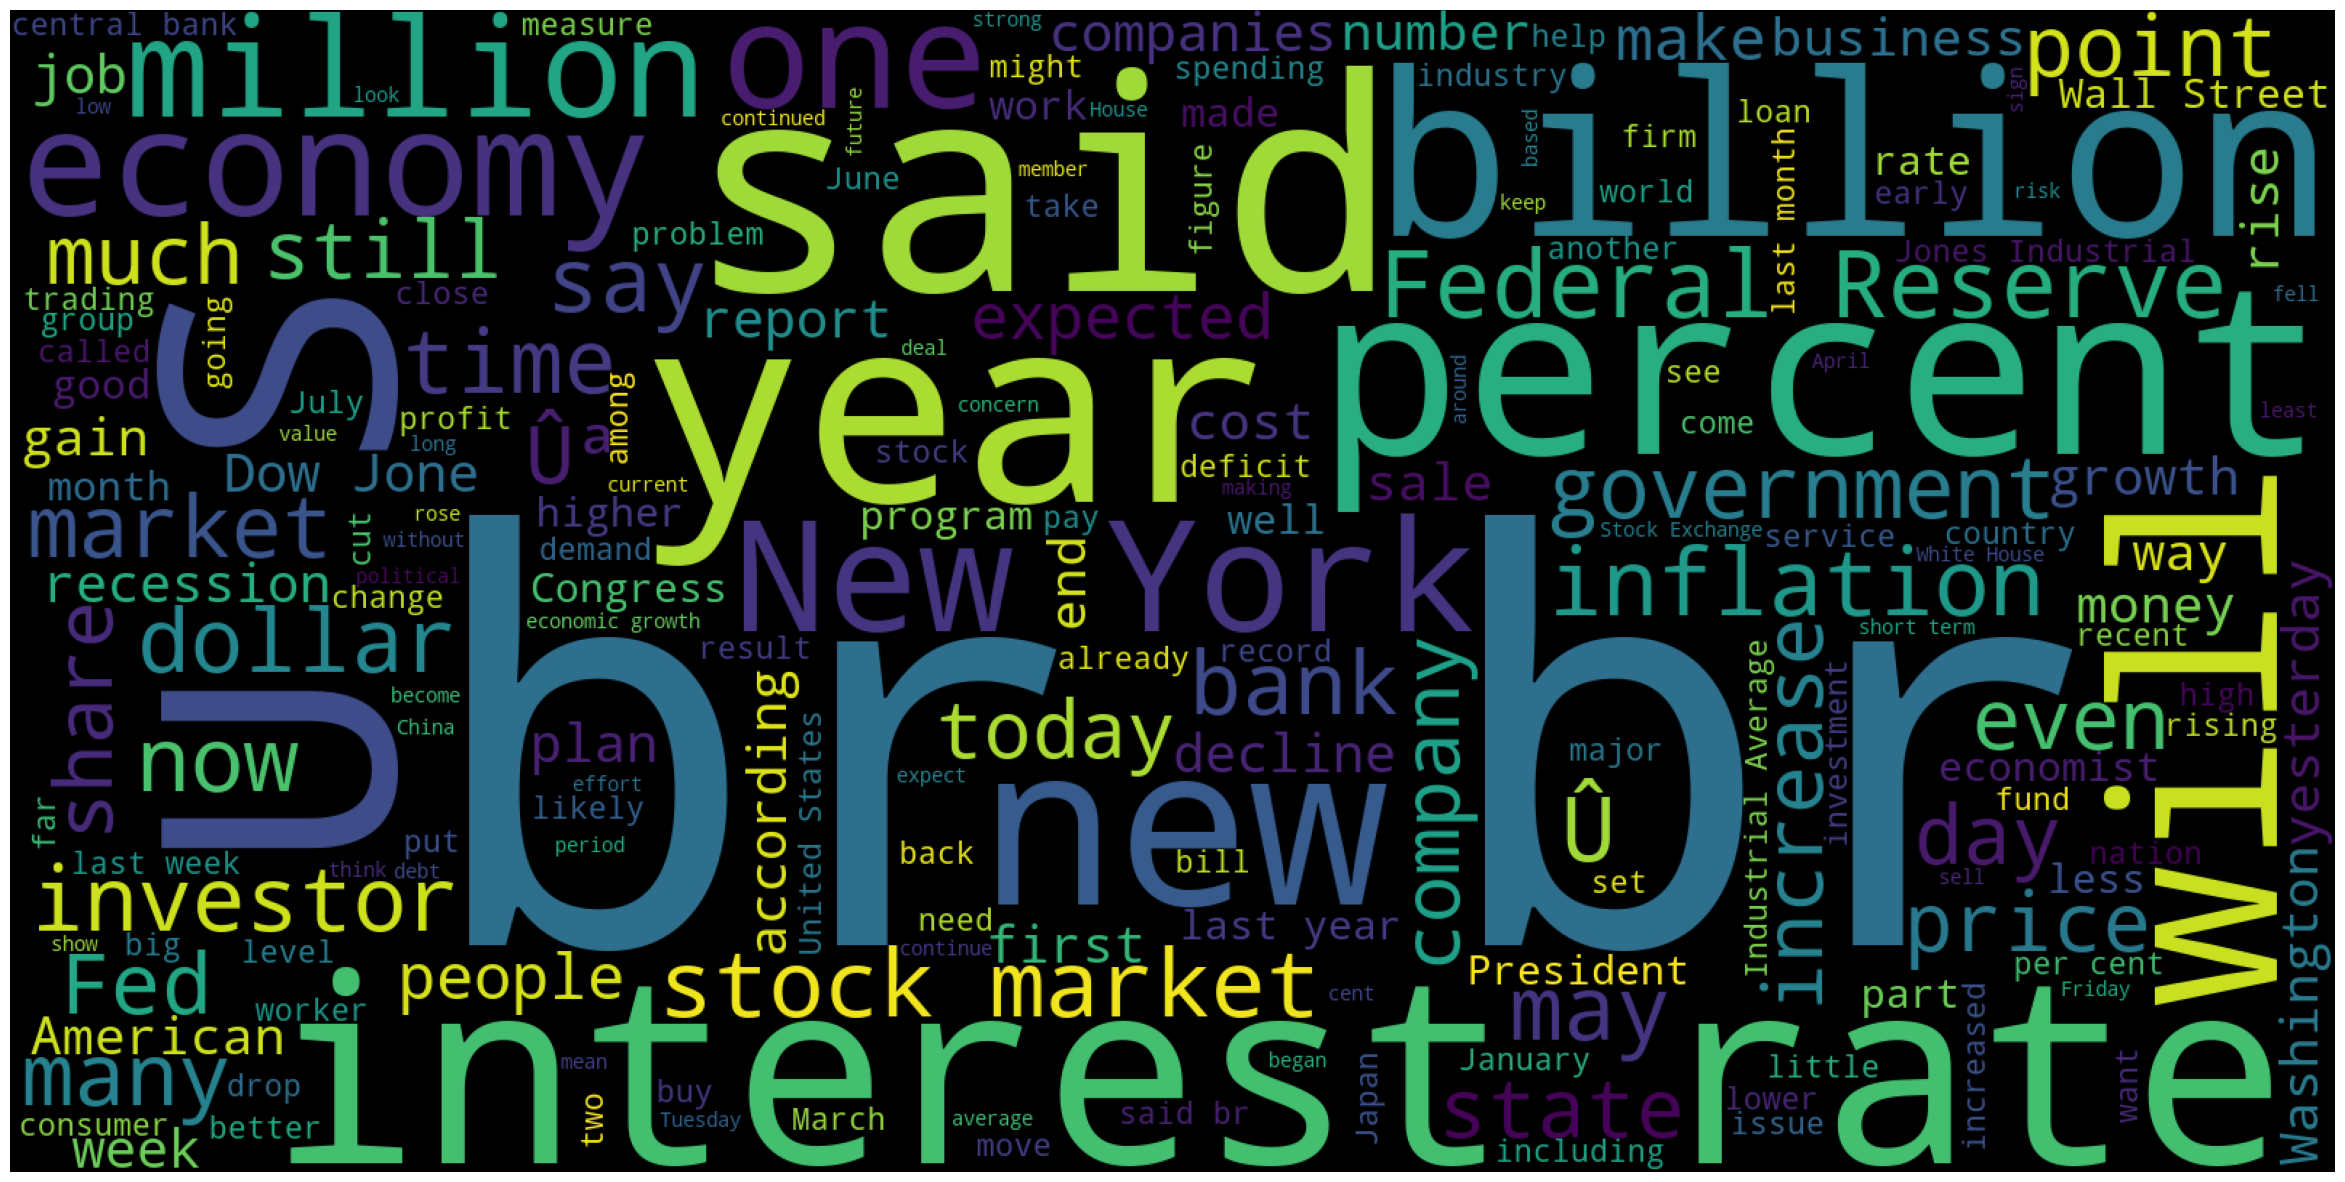

In [8]:
import matplotlib.pyplot as plt

plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

There is an imbalance in the data with **not relevant** being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [9]:
# removing the data where we don't want relevance="not sure".
df = df[df.relevance != "not sure"]

df.shape

(7991, 5)

In [10]:
# convert label to a numerical variable
df['relevance'] = df.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 

# Let us take only the two columns we need
df = df[["text", "relevance"]] 
df.shape

(7991, 2)

### **Step 1 - Identify Input and Output**

In [11]:
# Step 1: Identify Input and Output

X = df.text # the column text contains textual data to extract features from
y = df.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)

(7991,) (7991,)


### **Step 2 - Split the Data into Train and Test**

In [12]:
# Step 2: Split the data into train and test

from sklearn.model_selection import train_test_split

# split X and y into training and testing sets. 
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5993,) (5993,)
(1998,) (1998,)


### **Step 3 - Data Preprocessing on train data (X_train)**

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def display_wordcloud(data):
    wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(data))
    plt.figure(1,figsize=(30,20))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

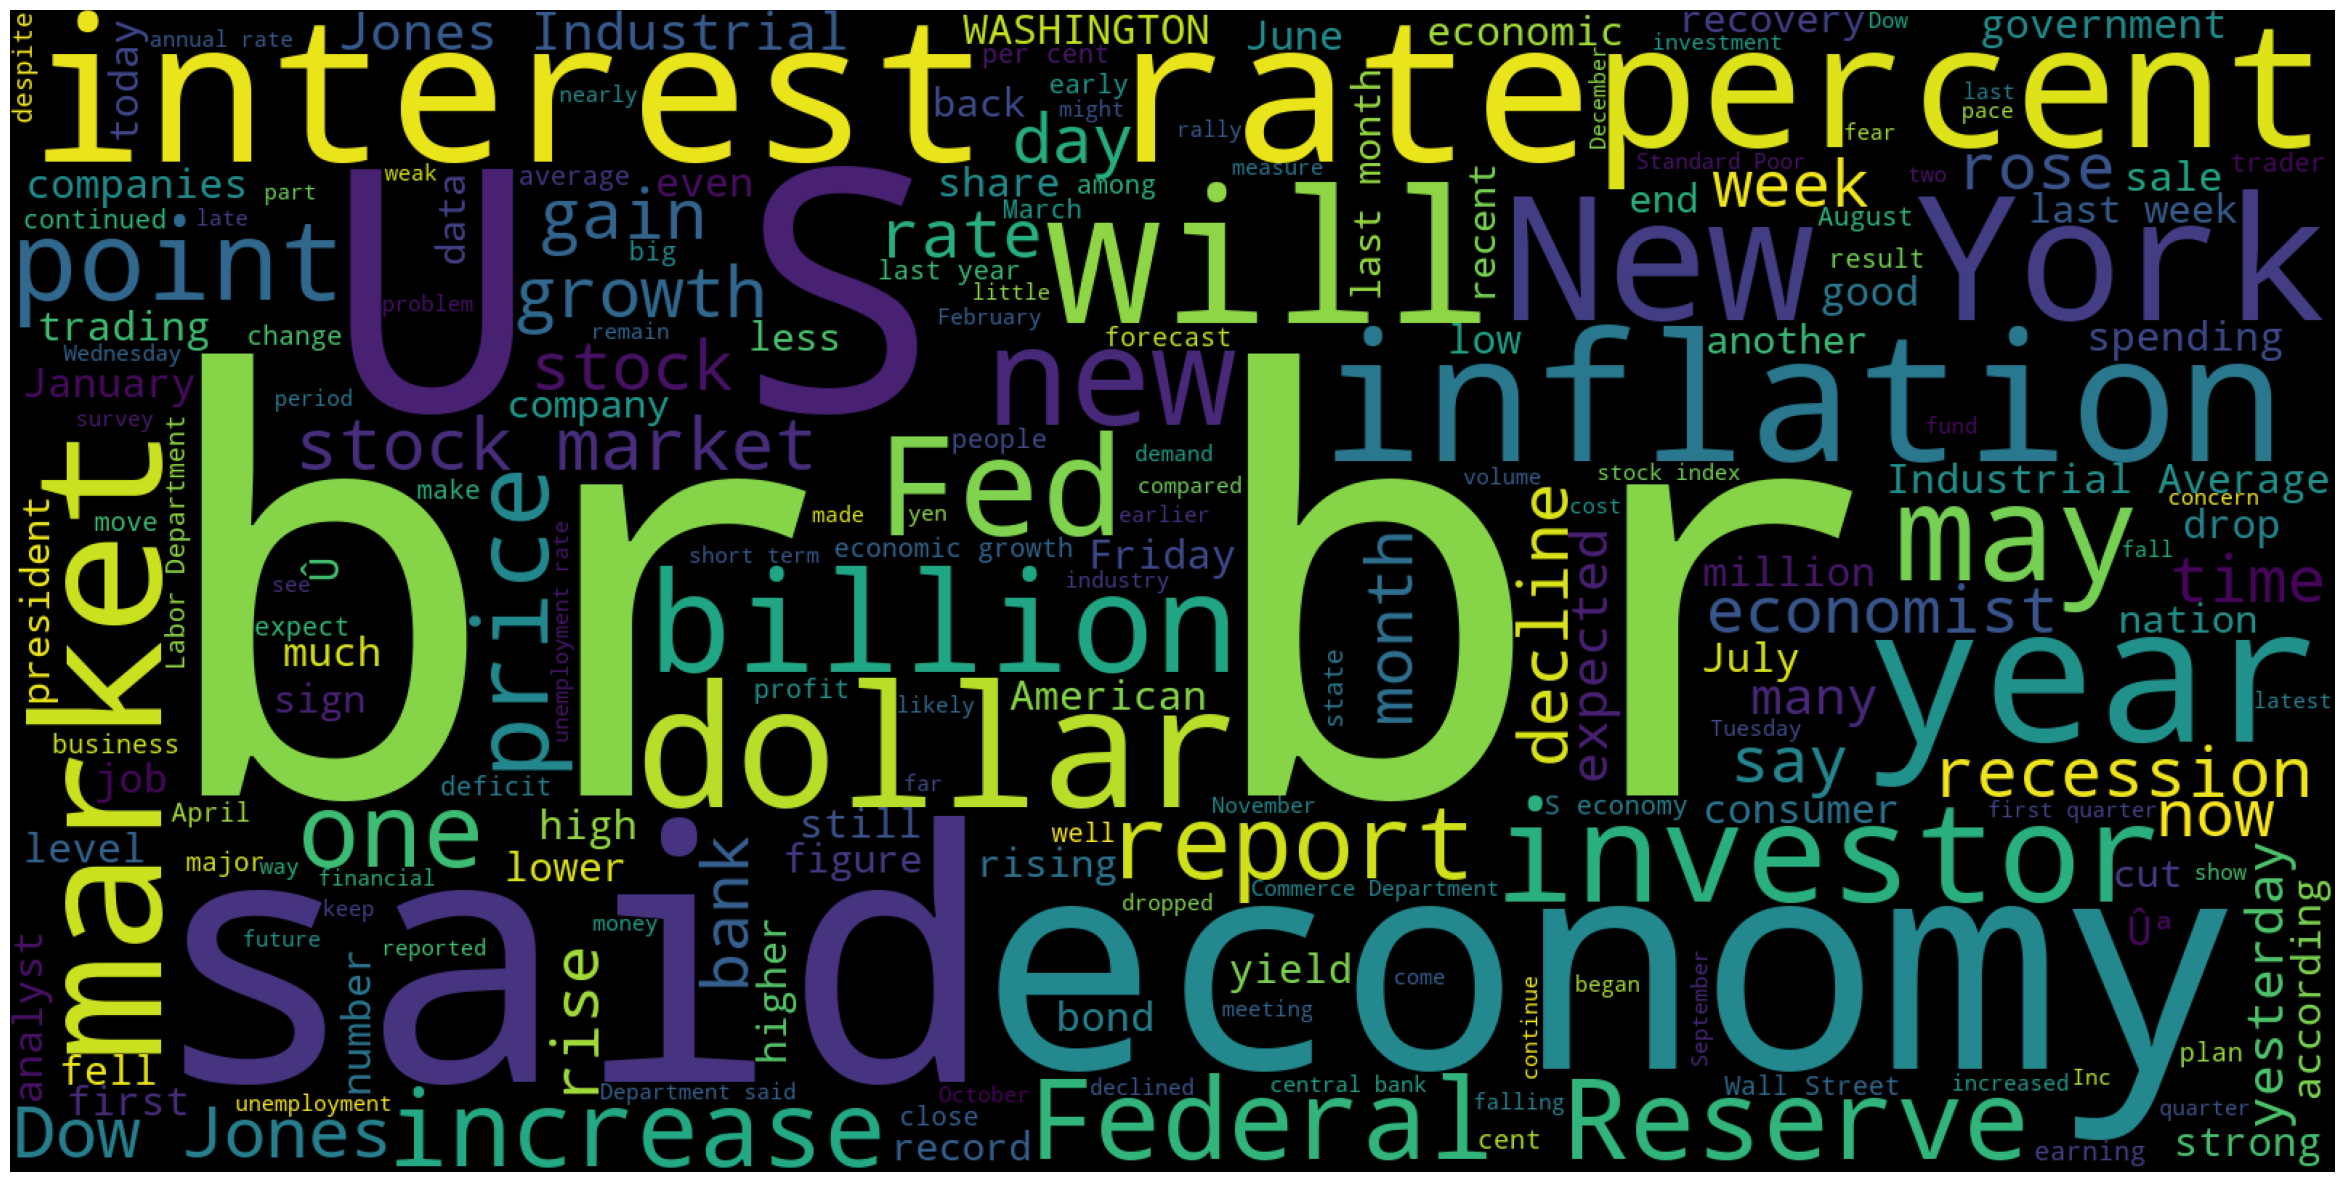

In [14]:
# Display the wordcloud for US Economy News Articles

display_wordcloud(X_train[y_train==1])

In [15]:
# Step 3: Data Preprocessing on train data (X_train)

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [16]:
# nltk.download('wordnet')

In [17]:
def clean(doc): # doc is a string of text
    # This text contains a lot of <br/> tags.
    doc = doc.replace("</br>", " ")
    
    # Remove punctuation and numbers.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [18]:
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: total: 17.1 s
Wall time: 17.3 s
(5993, 39644)


### **Step 4 - Data Preprocessing on test data (X_test)**

In [19]:
# Step 4: Data Preprocessing on test data (X_test)

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(1998, 39644)


### **Step 5 - Building a Model (i.e. Train the classifier)**

In [20]:
# Step 5: Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 0 ns
Wall time: 6.98 ms


MultinomialNB()

### **Step 6 - Evaluating on Train Data**

In [21]:
# Step 6: Evaluate on train data

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.accuracy_score(y_train, y_train_pred)

0.8231269814783915

In [22]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[4110,  805],
       [ 255,  823]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

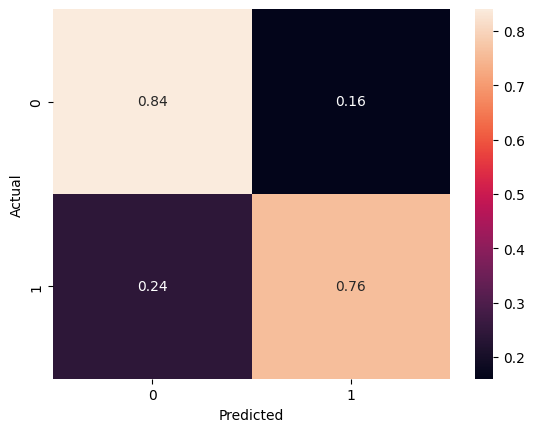

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### **Step 7 - Evaluate on Test Data**

In [24]:
# Step 7: Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_test_pred)

0.7717717717717718

Text(0.5, 23.52222222222222, 'Predicted')

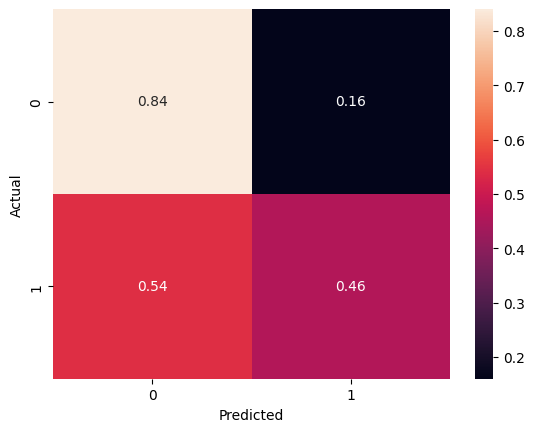

In [25]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [26]:
# # Understand that accuracy is influenced in the presence of data imbalance
# # Let's change the metric to F1 Score

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred))

Train Score (F1 Score): 0.6082779009608278
Test Score (F1 Score): 0.40932642487046633


At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. 

**Potential Reasons for poor classifier performance**
1. Perhaps we need to balance the data - Clearly there is class imbalance
2. Perhaps we need a better learning algorithm - Implement Logistic Regression, SVM, RF, etc...
3. Perhaps we should look for tuning the classifier's parameter with the help of Hyperparameter Tuning
4. Perhaps we need a better pre-processing and feature extraction mechanism - Right now we have a sparse and large feature vector

**Let's work with potential reason number 4.**  
Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

### **Going Back and Applying all the Steps Again**

In [27]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # instantiate a vectoriezer
%time X_train_dtm = vect.fit_transform(X_train) # use it to extract features from training data

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

CPU times: total: 16.7 s
Wall time: 16.9 s
(5993, 5000) (1998, 5000)


In [28]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 46.9 ms
Wall time: 7.69 ms


MultinomialNB()

In [29]:
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.f1_score(y_train, y_train_pred)

0.489665211062591

Text(0.5, 23.52222222222222, 'Predicted')

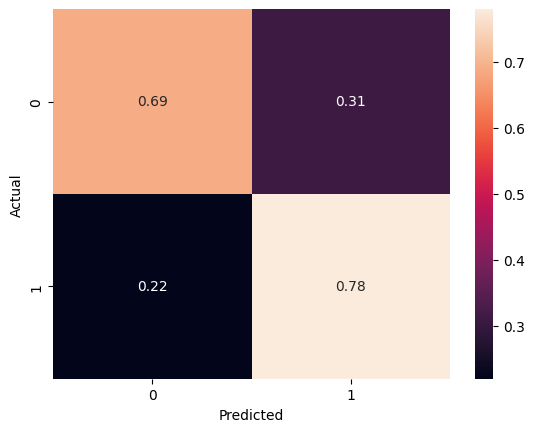

In [31]:
cm = metrics.confusion_matrix(y_train, y_train_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [32]:
y_test_pred = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

metrics.f1_score(y_test, y_test_pred)

0.42240587695133147

Text(0.5, 23.52222222222222, 'Predicted')

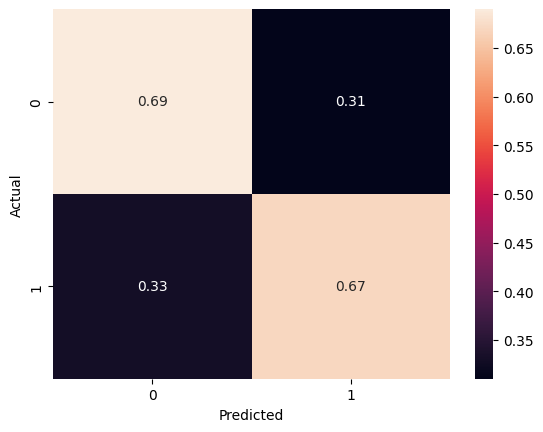

In [33]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### **Clearly, the performance on relevance classification got better.**

## **Creating an Optimal Workflow**

Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling.

In [34]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

In [35]:
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer()),
        ('nb', MultinomialNB())
    ]
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [{'vectorization__preprocessor' : [clean],
                   'vectorization__max_features' : MAX_FEATURES, 
                   'nb__alpha' : ALPHA}]

clf = GridSearchCV(
    estimator=pipe, 
    param_grid=parameter_grid, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf.fit(X_train, y_train)

print("Best estimator found on train set")
print(clf.best_estimator_)
print()

print('Score on Test Data: ', clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 15min 28s
Wall time: 15min 36s
Best estimator found on train set
Pipeline(steps=[('vectorization',
                 CountVectorizer(max_features=1500,
                                 preprocessor=<function clean at 0x00000296640C9AF0>)),
                ('nb', MultinomialNB(alpha=1))])

Score on Test Data:  0.40636704119850187


## **Caching to optimize the runtime**

Caching is a technique used in software engineering to improve performance by storing frequently accessed or computed data in a temporary storage location, known as a cache. The purpose of caching is to reduce the time and resources required to access or compute the same data repeatedly.

We can create the **Memory** object to cache the intermediate results of `vectorization`. 

This will avoid redundant computations of vectorization during the grid search, thereby optimizing the runtime. Adjust the cachedir parameter as needed to specify the location for caching the results.

In [36]:
import joblib
from joblib import Memory

import os

In [37]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

# Define the pipeline with caching
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer()),
        ('nb', MultinomialNB())
    ], 
    memory=memory
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [
    {
        'vectorization__preprocessor': [clean],
        'vectorization__max_features': MAX_FEATURES,
        'nb__alpha': ALPHA
    }
]

clf = GridSearchCV(
    estimator=pipe,
    param_grid=parameter_grid,
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf.fit(X_train, y_train)

print("Best estimator found on train set")
print(clf.best_estimator_)
print()

print('Score on Test Data: ', clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 8min 29s
Wall time: 8min 33s
Best estimator found on train set
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization',
                 CountVectorizer(max_features=1500,
                                 preprocessor=<function clean at 0x00000296640C9AF0>)),
                ('nb', MultinomialNB(alpha=1))])

Score on Test Data:  0.40636704119850187


In [38]:
# Serialization

best_model = clf.best_estimator_

joblib.dump(best_model, 'best_models/demo_model_nb.pkl')

['best_models/demo_model_nb.pkl']

In [39]:
# Deserialization

model = joblib.load('best_models/demo_model_nb.pkl')

# The following article was fetched from:
# https://www.cnbc.com/2024/03/01/euro-zone-inflation-q1-2024.html
# https://www.nbcnews.com/news/aliens-miami-mall-police-response-viral-speculation-rcna132524
new_data = [
    """Inflation in the 20-nation euro zone eased to 2.6% in February, 
    flash figures showed on Friday, but both the headline and core 
    figures were higher than expected.
    Economists polled by Reuters had forecast a headline reading of 2.5%.
    Core inflation, stripping out volatile components of energy, food, 
    alcohol and tobacco, was 3.1% — above the 2.9% expected.
    The European Union statistics agency said food, alcohol and tobacco 
    had the highest inflation rate in February at 4%, followed by services 
    at 3.9%.
    Energy prices, which had swollen last year as a result of Russia’s 
    invasion of Ukraine, continued to reduce, with the rate of deflation 
    moving from -6.1% to -3.7%.
    The headline print previously came in at 2.8% in January, with further 
    easing expected after price rises cooled in Germany, France and Spain.
    Investors are hunting for clues on when the European Central Bank will 
    start to bring down interest rates, with market pricing pointing to a 
    June cut. Yet many ECB officials still stress that they need spring wage 
    negotiations to conclude before they have a clearer picture of domestic 
    inflationary pressures.
    The February figures will be a mixed bag for policymakers, as core 
    inflation is holding above 3% even as the headline rate moves toward 
    the ECB’s 2% target. Price rises have nonethless cooled significantly 
    from their peak of 10.6% in October 2022.""", 
    """While many of the responses online appeared lighthearted, the posts 
    show just how quickly and easily misinformation can spread on social 
    media. The response also underscores an uptick in interest in extraterrestrial 
    activity, from hearings in Congress last summer about “unidentified aerial 
    phenomena” or “UAPs” to Mexico’s Congress showing off what it claimed were 
    “nonhuman” aliens. Both of those events also became prime meme fodder.
    However, Vega said aliens had nothing to do with Monday’s incident.
    “There were no aliens,” he wrote in the email. “No airports were closed. 
    Nothing is being withheld from the public. LOL.”
    Still, by Friday afternoon, “Miami Mall Alien” was trending on the social 
    media site X.
    “10ft Aliens/Creatures (caught on camera?) fired at inside and outside Miami 
    Mall, media silent, cops are covering it up saying kids were fighting with 
    fireworks, yet all these cop cars, & air traffic stopped that night except for 
    black military choppers…and no media coverage,” claimed one post on X, which on 
    Friday appeared to trigger a slew of conspiracy theories and memes.
    One person posted what appeared to be an AI image of a generic alien holding 
    shopping bags, and joked it was “The Miami Mall Alien.” """
]

prediction = model.predict(new_data)

print("Prediction:", prediction)

Prediction: [1 0]


#### **Here 1 means 'relevant' and 0 means 'not relevant'.**

In [42]:
# Let's analyse the models prediction time and model size

%time y_test_pred = model.predict(X_test)

print("Test Score (F1):", metrics.f1_score(y_test, y_test_pred))

CPU times: total: 5.25 s
Wall time: 5.29 s
Test Score (F1): 0.40636704119850187


In [43]:
print("Model Size:", os.path.getsize('best_models/demo_model_nb.pkl'), "Bytes")

Model Size: 521911 Bytes


## **Implementing Memoization to further improve the runtime**

As a software engineer, besides caching, you can employ several techniques to improve the time complexity of your code. Implement **memoization** to store the results of expensive function calls and reuse them when the same inputs occur again. This is particularly useful for dynamic programming problems.

In [44]:
# Improving the efficiency by applying cleaning the text data before hand

%time X_train_clean = X_train.apply(lambda doc: clean(doc))

CPU times: total: 15.5 s
Wall time: 15.7 s


In [45]:
%time X_test_clean = X_test.apply(lambda doc: clean(doc))

CPU times: total: 4.92 s
Wall time: 5.02 s


In [46]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

# Define the pipeline with caching
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer()),
        ('nb', MultinomialNB())
    ], 
    memory=memory
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [
    {
        'vectorization__max_features': MAX_FEATURES,
        'nb__alpha': ALPHA
    }
]

clf = GridSearchCV(
    estimator=pipe,
    param_grid=parameter_grid,
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf.fit(X_train_clean, y_train)

print("Best estimator found on train set")
print(clf.best_estimator_)
print()

print('Score on Test Data: ', clf.score(X_test_clean, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 26.6 s
Wall time: 27 s
Best estimator found on train set
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('nb', MultinomialNB(alpha=1))])

Score on Test Data:  0.40636704119850187


In [47]:
# Serialization

best_model = clf.best_estimator_

joblib.dump(best_model, 'best_models/demo_model_nb_unclean.pkl')

['best_models/demo_model_nb_unclean.pkl']

In [48]:
# Deserialization

model = joblib.load('best_models/demo_model_nb_unclean.pkl')

# The following article was fetched from:
# https://www.cnbc.com/2024/03/01/euro-zone-inflation-q1-2024.html
# https://www.nbcnews.com/news/aliens-miami-mall-police-response-viral-speculation-rcna132524
new_data = [
    """Inflation in the 20-nation euro zone eased to 2.6% in February, 
    flash figures showed on Friday, but both the headline and core 
    figures were higher than expected.
    Economists polled by Reuters had forecast a headline reading of 2.5%.
    Core inflation, stripping out volatile components of energy, food, 
    alcohol and tobacco, was 3.1% — above the 2.9% expected.
    The European Union statistics agency said food, alcohol and tobacco 
    had the highest inflation rate in February at 4%, followed by services 
    at 3.9%.
    Energy prices, which had swollen last year as a result of Russia’s 
    invasion of Ukraine, continued to reduce, with the rate of deflation 
    moving from -6.1% to -3.7%.
    The headline print previously came in at 2.8% in January, with further 
    easing expected after price rises cooled in Germany, France and Spain.
    Investors are hunting for clues on when the European Central Bank will 
    start to bring down interest rates, with market pricing pointing to a 
    June cut. Yet many ECB officials still stress that they need spring wage 
    negotiations to conclude before they have a clearer picture of domestic 
    inflationary pressures.
    The February figures will be a mixed bag for policymakers, as core 
    inflation is holding above 3% even as the headline rate moves toward 
    the ECB’s 2% target. Price rises have nonethless cooled significantly 
    from their peak of 10.6% in October 2022.""", 
    """While many of the responses online appeared lighthearted, the posts 
    show just how quickly and easily misinformation can spread on social 
    media. The response also underscores an uptick in interest in extraterrestrial 
    activity, from hearings in Congress last summer about “unidentified aerial 
    phenomena” or “UAPs” to Mexico’s Congress showing off what it claimed were 
    “nonhuman” aliens. Both of those events also became prime meme fodder.
    However, Vega said aliens had nothing to do with Monday’s incident.
    “There were no aliens,” he wrote in the email. “No airports were closed. 
    Nothing is being withheld from the public. LOL.”
    Still, by Friday afternoon, “Miami Mall Alien” was trending on the social 
    media site X.
    “10ft Aliens/Creatures (caught on camera?) fired at inside and outside Miami 
    Mall, media silent, cops are covering it up saying kids were fighting with 
    fireworks, yet all these cop cars, & air traffic stopped that night except for 
    black military choppers…and no media coverage,” claimed one post on X, which on 
    Friday appeared to trigger a slew of conspiracy theories and memes.
    One person posted what appeared to be an AI image of a generic alien holding 
    shopping bags, and joked it was “The Miami Mall Alien.” """
]

new_data_clean = [clean(doc) for doc in new_data]

prediction = model.predict(new_data)

print("Prediction:", prediction)

Prediction: [1 0]


In [49]:
# Let's analyse the models prediction time and model size

%time y_test_pred = model.predict(X_test_clean)

print("Test Score (F1):", metrics.f1_score(y_test, y_test_pred))

CPU times: total: 203 ms
Wall time: 200 ms
Test Score (F1): 0.40636704119850187


In [50]:
print("Model Size:", os.path.getsize('best_models/demo_model_nb_unclean.pkl'), "Bytes")

Model Size: 521879 Bytes


## **Putting it all together: Implementing various Algorithms to find the Best Model**

In [51]:
import warnings

warnings.filterwarnings('ignore')

In [52]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 39.6 s
Wall time: 39.8 s
Score on Test Data:  0.42240587695133147
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 6min 43s
Wall time: 6min 47s
Score on Test Data:  0.2612481857764876
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 31min 59s
Wall time: 32min 23s
Score on Test Data:  0.41962421711899794


In [53]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=2000)),
                ('classifier', DecisionTreeClassifier())])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=2000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.4,
                                    penalty='elasticnet', solver='saga'))])



In [54]:
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    %time y_test_pred = model.predict(X_test_clean)
    print("Test Score (F1)", metrics.f1_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

********** naive_bayes **********
CPU times: total: 250 ms
Wall time: 292 ms
Test Score (F1) 0.42240587695133147
Model Size: 707399 Bytes
********** decision_tree **********
CPU times: total: 266 ms
Wall time: 273 ms
Test Score (F1) 0.2612481857764876
Model Size: 598829 Bytes
********** logistic_regression **********
CPU times: total: 266 ms
Wall time: 273 ms
Test Score (F1) 0.41962421711899794
Model Size: 532910 Bytes
